In [ ]:
# notebook_regression_synthetic.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) generate synthetic dataset (or read your own csv by replacing this)
np.random.seed(42)
n = 1000
size = np.random.normal(120, 35, n).clip(30, 400)
bedrooms = np.random.poisson(3, n).clip(1, 7)
age = np.random.exponential(15, n).clip(0, 120)
distance_to_city = np.random.normal(10, 8, n).clip(0.2, 60)
has_garage = np.random.binomial(1, 0.6, n)
neighborhood_quality = np.random.choice([1,2,3,4,5], size=n, p=[0.1,0.2,0.4,0.2,0.1])

price = (
    0.8 * size +
    10 * bedrooms -
    0.5 * age -
    2.5 * distance_to_city +
    12 * has_garage +
    15 * neighborhood_quality +
    np.random.normal(0, 30, n)
)
price = price.clip(min=10)

df = pd.DataFrame({
    'size_m2': np.round(size,1),
    'bedrooms': bedrooms,
    'age_years': np.round(age,1),
    'distance_km': np.round(distance_to_city,2),
    'has_garage': has_garage,
    'neighborhood_quality': neighborhood_quality,
    'price_million_idr': np.round(price,2)
})

# optionally: save dataset to local CSV
os.makedirs("outputs", exist_ok=True)
csv_path = os.path.join("outputs", "synthetic_regression_dataset.csv")
df.to_csv(csv_path, index=False)
print("Dataset saved to:", csv_path)

# 2) EDA
print("\n--- Descriptive statistics ---")
print(df.describe().T)

# correlation
corr = df.corr()
print("\n--- Correlation with target ---")
print(corr['price_million_idr'].sort_values(ascending=False))

# 3) Plotting (matplotlib only)
plt.figure(figsize=(7,4))
plt.hist(df['price_million_idr'], bins=30)
plt.title("Distribusi Harga (million IDR)")
plt.xlabel("Harga (million IDR)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig("outputs/hist_price.png")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matriks Korelasi")
plt.tight_layout()
plt.savefig("outputs/corr_matrix.png")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df['size_m2'], df['price_million_idr'], alpha=0.5)
plt.xlabel("Luas (m2)")
plt.ylabel("Harga (million IDR)")
plt.title("Harga vs Luas")
plt.tight_layout()
plt.savefig("outputs/scatter_size_price.png")
plt.show()

# 4) Modeling: Linear, Ridge, Lasso, ElasticNet
X = df.drop(columns=['price_million_idr'])
y = df['price_million_idr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000),
    'ElasticNet': ElasticNet(max_iter=5000)
}

results = {}
best_estimators = {}
numeric_cols = X.columns.tolist()

for name, estimator in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', estimator)])
    if name == 'Ridge':
        param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 50, 100]}
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        cv_score = -grid.best_score_
        best_params = grid.best_params_
    elif name == 'Lasso':
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        cv_score = -grid.best_score_
        best_params = grid.best_params_
    elif name == 'ElasticNet':
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1], 'model__l1_ratio': [0.2, 0.5, 0.8]}
        grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        cv_score = -grid.best_score_
        best_params = grid.best_params_
    else:
        pipe.fit(X_train, y_train)
        best = pipe
        scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
        cv_score = -scores.mean()
        best_params = {}

    y_pred = best.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'cv_RMSE': round(cv_score,3),
        'test_RMSE': round(rmse,3),
        'test_MAE': round(mae,3),
        'test_R2': round(r2,3),
        'best_params': best_params
    }
    best_estimators[name] = best

# show results
print("\n--- Model comparison ---")
for k, v in results.items():
    print(k, v)

# pick best by test RMSE
best_name = min(results.keys(), key=lambda k: results[k]['test_RMSE'])
best_model = best_estimators[best_name]
print("\nBest model:", best_name)

# plots: pred vs actual & residuals
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--')
plt.xlabel("Actual Harga (million IDR)")
plt.ylabel("Predicted Harga (million IDR)")
plt.title(f"Prediksi vs Aktual ({best_name})")
plt.tight_layout()
plt.savefig(f"outputs/pred_vs_actual_{best_name}.png")
plt.show()

residuals = y_test - y_pred_best
plt.figure(figsize=(6,4))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Harga")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig("outputs/residuals.png")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Distribusi Residuals")
plt.xlabel("Residual (million IDR)")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.savefig("outputs/hist_residuals.png")
plt.show()

# coefficients (if linear-like)
if hasattr(best_model.named_steps['model'], 'coef_'):
    coefs = best_model.named_steps['model'].coef_
    coef_df = pd.DataFrame({'feature': numeric_cols, 'coefficient': coefs}).sort_values(by='coefficient', key=abs, ascending=False)
    print("\nTop coefficients:")
    print(coef_df)
    plt.figure(figsize=(6,4))
    plt.bar(coef_df['feature'], coef_df['coefficient'])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Koefisien Fitur ({best_name})")
    plt.tight_layout()
    plt.savefig("outputs/coefficients.png")
    plt.show()

# Save summary results to CSV
pd.DataFrame(results).T.to_csv("outputs/model_comparison_results.csv")
print("\nAll outputs saved in folder: outputs/")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
np.random.seed(42)
n = 1000

size = np.random.normal(120, 35, n).clip(30, 400)
bedrooms = np.random.poisson(3, n).clip(1, 7)
age = np.random.exponential(15, n).clip(0, 120)
distance_km = np.random.normal(10, 8, n).clip(0.2, 60)
has_garage = np.random.binomial(1, 0.6, n)
neighborhood_quality = np.random.choice(
    [1,2,3,4,5], size=n, p=[0.1,0.2,0.4,0.2,0.1]
)

price = (
    0.8 * size +
    10 * bedrooms -
    0.5 * age -
    2.5 * distance_km +
    12 * has_garage +
    15 * neighborhood_quality +
    np.random.normal(0, 30, n)
)

price = price.clip(min=10)


In [4]:
df = pd.DataFrame({
    'size_m2': size,
    'bedrooms': bedrooms,
    'age_years': age,
    'distance_km': distance_km,
    'has_garage': has_garage,
    'neighborhood_quality': neighborhood_quality,
    'price_million_idr': price
})

df.to_csv("dataset_regresi_rumah.csv", index=False)
df.head()


,size_m2,bedrooms,age_years,distance_km,has_garage,neighborhood_quality,price_million_idr
0,137.384995,1,3.210460,14.698099,0,3,157.035635
1,115.160749,2,2.072927,8.354977,1,3,135.103301
2,142.669099,1,5.304324,10.662661,1,5,137.270881
3,173.306045,7,22.715195,4.174625,1,1,152.366442
4,111.804632,6,9.569274,23.985097,1,3,179.521813


In [5]:
df.describe()


,size_m2,bedrooms,age_years,distance_km,has_garage,neighborhood_quality,price_million_idr
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,120.708932,3.010000,15.044751,10.070166,0.623000,2.982000,146.671202
std,34.178379,1.599518,15.638912,7.282272,0.484877,1.048225,48.960520
min,30.000000,1.000000,0.058891,0.200000,0.000000,1.000000,10.000000
25%,97.334339,2.000000,4.089895,4.414857,0.000000,2.000000,113.904520
50%,120.885521,3.000000,10.089353,9.528219,1.000000,3.000000,145.803647
75%,142.678036,4.000000,20.462196,14.871466,1.000000,4.000000,179.084590
max,254.845602,7.000000,112.878052,34.903282,1.000000,5.000000,297.967608


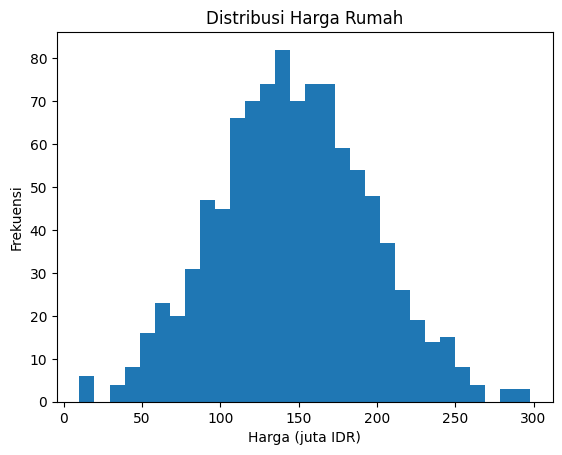

In [6]:
plt.figure()
plt.hist(df['price_million_idr'], bins=30)
plt.title("Distribusi Harga Rumah")
plt.xlabel("Harga (juta IDR)")
plt.ylabel("Frekuensi")
plt.show()


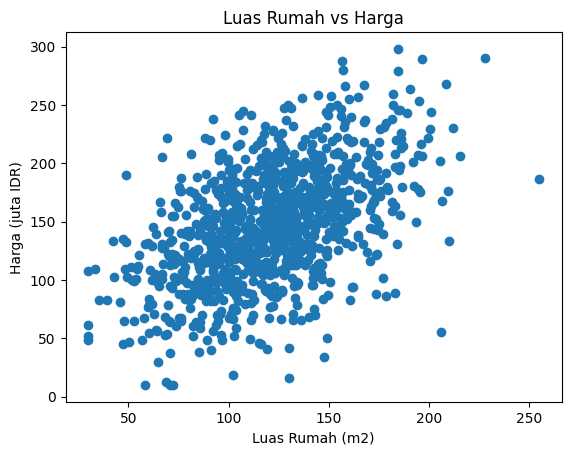

In [7]:
plt.figure()
plt.scatter(df['size_m2'], df['price_million_idr'])
plt.xlabel("Luas Rumah (m2)")
plt.ylabel("Harga (juta IDR)")
plt.title("Luas Rumah vs Harga")
plt.show()


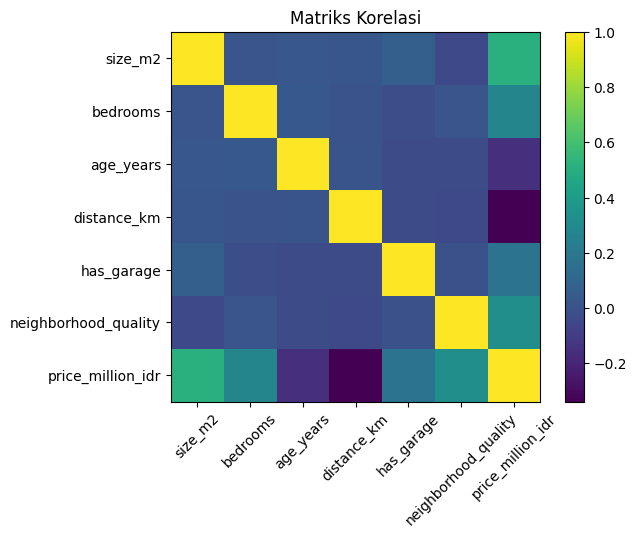

In [8]:
plt.figure()
plt.imshow(df.corr())
plt.colorbar()
plt.xticks(range(len(df.columns)), df.columns, rotation=45)
plt.yticks(range(len(df.columns)), df.columns)
plt.title("Matriks Korelasi")
plt.show()


In [9]:
X = df.drop(columns=['price_million_idr'])
y = df['price_million_idr']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet()
}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE :", mean_absolute_error(y_test, y_pred))
    print("R²  :", r2_score(y_test, y_pred))



 Linear Regression
RMSE: 30.57977714135707
MAE : 24.382692037383165
R²  : 0.6318327101840872

 Ridge Regression
RMSE: 30.5828485633151
MAE : 24.387417124075174
R²  : 0.6317587492862446

 Lasso Regression
RMSE: 30.87654097942007
MAE : 24.717115504249847
R²  : 0.6246522201203497

 ElasticNet Regression
RMSE: 34.208256054742684
MAE : 27.872610394380327
R²  : 0.5392785449715989


In [ ]:
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Harga Aktual")
plt.ylabel("Harga Prediksi")
plt.title("Prediksi vs Aktual")
plt.show()
